Le notebook Rentabilité contient le coeur de notre projet : en indiquant une position de départ, une quantité de carburant et le type de carburant, notre fonction va retourner la station essence dans laquelle il est le plus rentable d'aller faire le plein. On prend en compte la distance, la consommation, le prix du trajet et le prix du carburant dans la station d'arrivée 

In [20]:
import pandas as pd
import module_projet as md
from geopy.geocoders import Nominatim
import osmnx as ox
import networkx as nx

In [21]:
import module_projet as md

Ce que nous avons fait précedemment a le défaut de calculer la distance à vol d'oiseau ce qui n'est pas nécessairement e chemin suivi par les voies routières. Ainsi, on va vouloir calculer des itinéraires pour déterminer les stations les plus proches en voiture.

Le module osmnx contient des fonctions qui vont permettrent de créer des graphes à partir des données de OpenStreetMap :

In [22]:
def create_graph(loc, dist, transport_mode, loc_type="address"):
###Transport mode = ‘walk’, ‘bike’, ‘drive’, ‘drive_service’, ‘all’, ‘all_private’, ‘none’
    if loc_type == "address":
        G = ox.graph_from_address(loc, dist=dist, network_type=transport_mode)
    elif loc_type == "points":
        G = ox.graph_from_point(loc, dist=dist, network_type=transport_mode )
    return G

In [23]:
G = create_graph("Paris", 10000, "drive")

dont on pondère les arêtes : 

In [24]:
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
G = ox.distance.add_edge_lengths(G) #on va utiliser cette pondération par la suite car nous souhaitions obtenir la longueur du chemin sous la forme d'une distance

ce qui à l'aide d'un algorithme de recherche du plus court chemin (basé sur Dijkstra) permet de créer des itinéraires entre deux points : 

In [25]:
def itinéraire(position, station):
    a,b = position
    x,y = station
    start_node = ox.nearest_nodes(G, a,b) #trouve le noeud du graphe le plus proche de la position
    end_node = ox.nearest_nodes(G, x,y) 
    route = nx.shortest_path(G, start_node, end_node, weight='length') #trouve le plus court chemin
    length = nx.shortest_path_length(G, source=start_node, target=end_node, weight='length', method="dijkstra") #trouve la longueur de ce chemin
    return(route, length)

qui renvoie le meilleur itinéraire (en terme de distance) entre deux points ainsi que sa longueur (en mètre). Cela permet alors de trouver les x stations les plus proches en terme de distance à parcourir en voiture et non à vol d'oiseau : 

In [26]:
def x_plus_proche(data, position , carb, nbr_stations):
    data_mask = data['Nom Officiel Région']=='Île-de-France'
    data_1 = data[data_mask]
    data_2 = md.data_carb(data_1, carb, ['adresse', 'ville', 'prix_valeur', 'prix_nom', 'geom'])
    pos = list(map(float,md.Adresse_to_gps2(position).split(',')))
    def iti(station):
        pos_sta = list(map(float, station.split(',')))
        a = pos_sta[0]
        pos_sta[0] = pos_sta[1]
        pos_sta[1] = a
        return(itinéraire(pos, pos_sta)[1])
    vector = data_2['geom'].apply(iti).sort_values().head(nbr_stations)
    return(vector)

L'étape finale consistant en le fait d'afficher à l'utilisateur son itinéraire entre sa position et la station-service préalablement sélectionnée comme étant la plus rentable, nous allons montrer comme cela est possibe ici : 

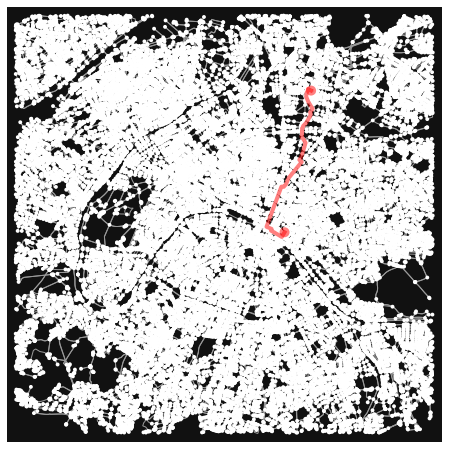

(<Figure size 576x576 with 1 Axes>, <AxesSubplot: >)

In [27]:
start = (2.3592784,48.8555424)
end = (2.378077,48.916340)
route = itinéraire(start, end)[0]
ox.plot_graph_route(G, route)

On récupère les données, on travaille ici sur la base de données instantanées

In [28]:
dat_inst = pd.read_csv('data/fichier_inst.csv', sep= ';')

Nous avons besoin d'informations sur l'utilisateur pour faire marcher notre algorithme

In [29]:
adresse="1 rue de Rivoli, France, Paris"
carburant="Gazole"
quanti=50

df_renta=md.data_carb(dat_inst, carburant, ['id', 'ville', 'geom','prix_valeur','prix_nom'])

In [30]:

#fonctions a récuperer dans le md

def Adresse_to_gps(Adresse) : 

    geolocator = Nominatim(user_agent="arman.akgonul@ensae.fr")
    location = geolocator.geocode(Adresse, timeout=10000)
    return str(str(location.latitude) + ','+ str(location.longitude))


def data_carb(df, carb, colonnes_utiles):
    data_1 = df[df.prix_nom == carb]
    d = data_1[colonnes_utiles]
    d.drop_duplicates(keep = 'first', inplace=True) 
    return d

# a ajouter : un traitement des NaN
    return d


On a donc besoin d'une fonction qui calcule le prix du plein en fonction de la station d'essence choisie

In [31]:
df_opti=md.dix_plus_proche_card(dat_inst, adresse, carburant) #voir module pour la fonction

In [32]:
def prix_plein(Quantité, position, station) : 
    A = list(map(float,position.split(',')))
    B = list(map(float,df_opti.iloc[station,2].split(',')))
    
    R,Dist= itinéraire(A,B)   #calcul de la distance avec la station 
    D=Dist/1000 #on converti la distance en kilomètre
    conso_trajet=D*0.06 #calcul du nb de litre d'essence necessaire pour aller a la station
    P=Quantité+conso_trajet #calcul du nb de litre necessaire pour faire le plein après le trajet
    prix_L=df_opti.iloc[station,3] #prix au litre à la station
    px_plein=prix_L*P #prix du plein de base + prix du trajet
    return px_plein

In [33]:
df_opti=df_opti.assign(cout=1) #nouvelle colonne avec le cout du plein en tenant compte du trajet et du prix

Ici on fait une boucle qui calcule le prix du plein pour toutes les stations pour trouver celle où il est le plus rentable d'aller

In [34]:
position=md.Adresse_to_gps(adresse) #on sort cette ligne de la boucle, sinon le package "Nomatim" nous bloque pour usage trop récurrent
for i in range(len(df_opti)) : 
    C=prix_plein(50,position,i) #on calcule le prix du plein pour chaque station
    df_opti.iloc[i,5]=C #on ajoute ce prix dans le dataframe


Enfin, on affiche la meilleure station calculée par l'algorithme

In [35]:
df_optio=df_opti.sort_values('cout')
print(df_opti.head(1)) #station la plus rentable

                      adresse  ville             geom  prix_valeur prix_nom  \
6472  175 Avenue Ledru-Rollin  PARIS  48.85667,2.3791         2.49   Gazole   

       cout  
6472  124.5  
